In [1]:
import copy
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from utils import quantize, generate_dataset, training_algo, adding_noise_model, testing
from models_utils import MLP, Linear_noisy, Noisy_Inference
from collections import OrderedDict

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print( f'you are using a Mac-based GPU' )
elif torch.cuda().is_available():
    device = torch.cuda.device(0)
    print( 'You are using a '+str(torch.cuda.get_device_name(0)) )
else: 
    device = torch.device('cpu')
    print( f'you are using a: {device}' )

you are using a Mac-based GPU


In [ ]:
### Reproducibility in RNG
seed = 14
torch.manual_seed( seed )
random.seed( seed )
np.random.seed( seed )

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

### Importing the dataset

In [2]:
batch_size = 32
train_loader, test_loader = generate_dataset(task='mnist', train_batch_size=batch_size, test_batch_size=batch_size)
data_loaders = [train_loader, test_loader]

### Vanilla (Standard) training

In [5]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3])
acc_test_vanilla = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_vanilla_ref = np.zeros( n_models )

for m in range(n_models):
    model = MLP()
    data_loaders = [train_loader, test_loader]
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    model_trained, [_, _], [acc_test, loss_test] = training_algo( training_type='normal', model=model, data_loaders=data_loaders,
                                                                    optimizer=optimizer, clip_w=2.5, lr=1e-3, epochs=25, epochs_noise=2, 
                                                                    print_every=1, verbose=False, device=device )
    acc_test, _ = testing( model_trained, test_loader=test_loader, verbose=True, device=device )
    acc_test_vanilla_ref[m] = acc_test
    for n, noise_sd in enumerate(noise_sd_list):
        model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
        acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
        acc_test_vanilla[m, n] = acc_test_noise

-- Test accuracy 97.48% Test loss 0.0829
-- Test accuracy 97.70% Test loss 0.0823
-- Test accuracy 97.51% Test loss 0.0801
-- Test accuracy 97.35% Test loss 0.0832
-- Test accuracy 97.50% Test loss 0.0784


In [7]:
import pickle
epochs = 25; lr = 1e-3
dict_results_vanilla = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_vanilla' : acc_test_vanilla,
    'acc_test_vanilla_ref' : acc_test_vanilla_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/Vanilla_MNIST_MLP_new.pkl'
pickle.dump( dict_results_vanilla, open( dir_save, 'wb' ) )

### Noise in backprop phase

In [8]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3])
acc_test_nudging = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_nudging_ref = np.zeros( n_models )
data_loaders = [train_loader, test_loader]

for m in range(n_models):
    model = MLP()
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    model_trained_nudged, _, _ = training_algo( training_type='noise_fine_tuning', model=model, data_loaders=data_loaders, 
                                                optimizer=optimizer, clip_w=2.5, lr=1e-3, epochs=25, epochs_noise=3, 
                                                print_every=1, noise_sd=1e-2, noise_every=100, verbose=False )
    acc_test, _ = testing( model_trained_nudged, test_loader=test_loader, verbose=True )
    acc_test_nudging_ref[m] = acc_test
    for n, noise_sd in enumerate( noise_sd_list ):
        model_trained_nudged_noisy = adding_noise_model( model=model_trained_nudged, add_quantization=False, add_noise=True, noise_sd=noise_sd )
        acc_test_noise, _ = testing( model_trained_nudged_noisy, test_loader=test_loader, verbose=False )
        acc_test_nudging[m, n] = acc_test_noise

-- Test accuracy 97.42% Test loss 0.0860
-- Test accuracy 97.39% Test loss 0.0872
-- Test accuracy 97.38% Test loss 0.0862
-- Test accuracy 97.45% Test loss 0.0856
-- Test accuracy 97.32% Test loss 0.0887


In [9]:
import pickle
epochs = 25; lr = 1e-3
dict_results_NoiseBack = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_nudging' : acc_test_nudging,
    'acc_test_nudging_ref' : acc_test_nudging_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseBack_MNIST_MLP_new.pkl'
pickle.dump( dict_results_NoiseBack, open( dir_save, 'wb' ) )

### Noise in Forward phase only

In [17]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3])
acc_test_fon = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_fon_ref = np.zeros( n_models )
noise_sd_train = 0.3

for m in range(n_models):
    model = MLP(noise_inference=True, noise_sd=noise_sd_train)
    data_loaders = [train_loader, test_loader]
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    model_trained, _, _ = training_algo( training_type='normal', model=model, data_loaders=data_loaders, 
                                        optimizer=optimizer, clip_w=2.5, lr=1e-3, epochs=25, epochs_noise=2, 
                                        print_every=1, verbose=False, device=device )
    # remove noise from inference
    for l in model.layers:
        # model.layers[l].remove_noise = True
        model.layers[l].noise_inference = False

    acc_test, _ = testing( model_trained, test_loader=test_loader, verbose=True, device=device )
    acc_test_fon_ref[m] = acc_test
    for n, noise_sd in enumerate(noise_sd_list):
        model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
        acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
        acc_test_fon[m, n] = acc_test_noise

-- Test accuracy 93.42% Test loss 0.3156
-- Test accuracy 93.05% Test loss 0.3126
-- Test accuracy 93.06% Test loss 0.3173
-- Test accuracy 93.00% Test loss 0.3164
-- Test accuracy 93.51% Test loss 0.2905


In [18]:
import pickle
epochs = 25; lr = 1e-3
dict_results_NoiseForw = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_fon' : acc_test_fon,
    'acc_test_fon_ref' : acc_test_fon_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = f'/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_new_{noise_sd_train}.pkl'
pickle.dump( dict_results_NoiseForw, open( dir_save, 'wb' ) )

#### Plotting the results

In [5]:
import pickle
dir_vanilla = '/Users/filippomoro/Documents/Training_with_memristors/Results/Vanilla_MNIST_MLP_new.pkl'
with open(dir_vanilla, 'rb') as file_handler:
    dict_results_vanilla = pickle.load( file_handler )
dir_NoiseBack = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseBack_MNIST_MLP_new.pkl'
with open(dir_NoiseBack, 'rb') as file_handler:
    dict_results_NoiseBack = pickle.load( file_handler )
dir_NoiseForw = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_new_0.2.pkl'
with open(dir_NoiseForw, 'rb') as file_handler:
    dict_results_NoiseForw = pickle.load( file_handler )

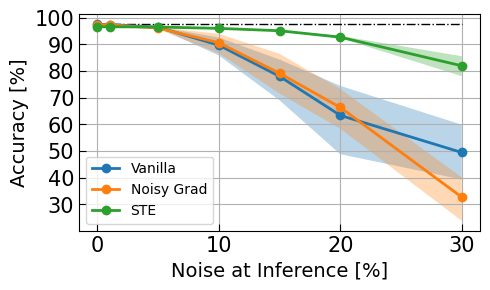

In [25]:
noise_sd_list = dict_results_vanilla['noise_sd_list']
acc_test_vanilla = 100*dict_results_vanilla['acc_test_vanilla']
acc_test_vanilla_ref = 100*dict_results_vanilla['acc_test_vanilla_ref']
acc_test_nudging = 100*dict_results_NoiseBack['acc_test_nudging']
acc_test_nudging_ref = 100*dict_results_NoiseBack['acc_test_nudging_ref']
acc_test_fon = 100*dict_results_NoiseForw['acc_test_fon']

fig, ax = plt.subplots( figsize=(5,3) )
# reference accuracy w/out noise
ax.hlines( np.mean( acc_test_vanilla_ref, axis=0 ), noise_sd_list[0]*100, noise_sd_list[-1]*100, lw=1, linestyle='-.', color='k')
# vanilla training
ax.plot( 100*noise_sd_list, np.mean( acc_test_vanilla, axis=0 ), lw=2, marker='o', ms=6, label='Vanilla')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_vanilla, axis=0, q=0.5-0.38 ), np.quantile( acc_test_vanilla, axis=0, q=0.5+0.38 ), alpha=0.3 )
# with the noise in backward phase
ax.plot( 100*noise_sd_list, np.mean( acc_test_nudging, axis=0 ), lw=2, marker='o', ms=6, label='Noisy Grad')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_nudging, axis=0, q=0.5-0.38 ), np.quantile( acc_test_nudging, axis=0, q=0.5+0.38 ), alpha=0.3 )
# with the noise in forward phase
ax.plot( 100*noise_sd_list, np.mean( acc_test_fon, axis=0 ), lw=2, marker='o', ms=6, label='STE')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_fon, axis=0, q=0.5-0.38 ), np.quantile( acc_test_fon, axis=0, q=0.5+0.38 ), alpha=0.3 )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
#ax.set_xscale('log')
ax.set_yticks( np.arange( 30,110,10 ) )
ax.set_xlabel('Noise at Inference [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()
ax.legend( prop={'size':10} )

## saving the plot
plt.tight_layout()
root_path_results = '/Users/filippomoro/Documents/Training_with_memristors/Results'
file_save_plot = root_path_results + '/MNIST_noise_at_inference.pdf'
fig.savefig( file_save_plot, dpi=300, transparent=True )

In [6]:
noise_sd_train_list = np.array( [0.05, 0.1, 0.2, 0.3] )
accuracy_ste = []
for n, noise_sd in enumerate(noise_sd_train_list):
    dir_NoiseForw = f'/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_new_{noise_sd}.pkl'
    with open(dir_NoiseForw, 'rb') as file_handler:
        dict_results_NoiseForw = pickle.load( file_handler )
        accuracy_ste.append( 100*dict_results_NoiseForw['acc_test_fon'] )
accuracy_ste = np.stack(accuracy_ste)

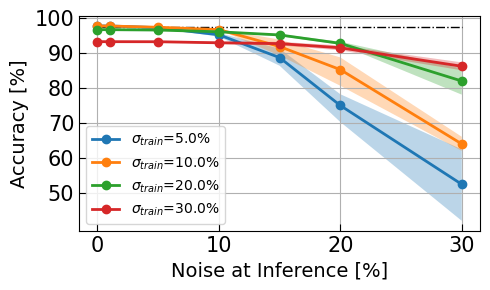

In [31]:
fig, ax = plt.subplots( figsize=(5,3) )
# reference accuracy w/out noise
ax.hlines( np.mean( acc_test_vanilla_ref, axis=0 ), noise_sd_list[0]*100, noise_sd_list[-1]*100, lw=1, linestyle='-.', color='k')
# with the noise in forward phase
for n, noise_sd in enumerate(noise_sd_train_list):
    ax.plot( 100*noise_sd_list, np.mean( accuracy_ste[n], axis=0 ), lw=2, marker='o', ms=6, label=r'$\sigma_{train}$='+str(noise_sd*100)+'%')
    ax.fill_between( 100*noise_sd_list, np.quantile( accuracy_ste[n], axis=0, q=0.5-0.38 ), np.quantile( accuracy_ste[n], axis=0, q=0.5+0.38 ), alpha=0.3 )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
#ax.set_xscale('log')
ax.set_yticks( np.arange( 50,110,10 ) )
ax.set_xlabel('Noise at Inference [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()
ax.legend( prop={'size':10} )

## saving the plot
plt.tight_layout()
root_path_results = '/Users/filippomoro/Documents/Training_with_memristors/Results'
file_save_plot = root_path_results + '/MNIST_noise_at_inference_2.pdf'
fig.savefig( file_save_plot, dpi=300, transparent=True )

### Test of Forward and Backward noise training

In [ ]:
### Forward Noise
forward_noise = [0.025, 0.05, 0.1]
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
acc_test_fon = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_fon_ref = np.zeros( n_models )

for f, forw_noise in enumerate( forward_noise ):
    for m in range(n_models):
        model = MLP(noise_inference=True, noise_sd=forw_noise)
        data_loaders = [train_loader, test_loader]
        model_trained, _, _ = training_algo( training_type='normal', model=model, data_loaders=data_loaders, clip_w=2.5,
                                            lr=1e-3, epochs=20, epochs_noise=2, print_every=1, verbose=True, device=device )
        # remove noise from inference
        for l in model.layers:
            model.layers[l].remove_noise = True
        for n, noise_sd in enumerate(noise_sd_list):
            model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
            acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
            acc_test_fon[m, n, f] = acc_test_noise

In [ ]:
import pickle
epochs = 20; lr = 1e-3
dict_results_NoiseForw = {
    'forward_noise' : forward_noise,
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_fon' : acc_test_fon,
    'acc_test_fon_ref' : acc_test_fon_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_analysis.pkl'
pickle.dump( dict_results_NoiseForw, open( dir_save, 'wb' ) )

In [ ]:
### Backward noise
backward_noise = [0.025, 0.05, 0.1]

n_models = 5
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
acc_test_nudging = np.zeros( (n_models, len(noise_sd_list), len(backward_noise)) )
data_loaders = [train_loader, test_loader]

for b, back_noise in enumerate( backward_noise ):
    for m in range(n_models):
        model = MLP()
        model_trained_nudged, _, _ = training_algo( training_type='noise_fine_tuning', model=model, data_loaders=data_loaders, clip_w=2.5,
                                                    lr=1e-3, epochs=20, epochs_noise=3, print_every=1, noise_sd=back_noise, noise_every=100, verbose=False )
        for n, noise_sd in enumerate( noise_sd_list ):
            model_trained_nudged_noisy = adding_noise_model( model=model_trained_nudged, add_quantization=False, add_noise=True, noise_sd=noise_sd )
            acc_test_noise, _ = testing( model_trained_nudged_noisy, test_loader=test_loader, verbose=False )
            acc_test_nudging[m, n, b] = acc_test_noise

In [ ]:
import pickle
epochs = 20; lr = 1e-3
dict_results_NoiseBack = {
    'backward_noise' : backward_noise,
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_nudging' : acc_test_nudging,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseBack_MNIST_MLP_analysis.pkl'
pickle.dump( dict_results_NoiseForw, open( dir_save, 'wb' ) )

# Quantization Aware Training

In [ ]:
model = MLP(noise_inference=True, noise_sd=forw_noise)

In [ ]:
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15]) 

In [29]:
model = MLP(  )
#model = MLP(noise_inference=True, noise_sd=1e-3)
model.generate_hidden_weights()

data_loaders = [train_loader, test_loader]
model_trained, [accs_train, losses_train], [acc_test, loss_test] = training_algo( training_type='qat_noise', model=model, data_loaders=data_loaders,
                                                                                    clip_w=2.5, lr=1e-3, epochs=10, epochs_noise=2, num_levels=4, noise_sd=1e-2,
                                                                                    print_every=1, verbose=True, device=device )

Epoch 0, Train accuracy 91.57% Test loss 0.3019
Epoch 1, Train accuracy 95.63% Test loss 0.1444
Epoch 2, Train accuracy 96.82% Test loss 0.1062
Epoch 3, Train accuracy 97.37% Test loss 0.0868
Epoch 4, Train accuracy 97.71% Test loss 0.0730
Epoch 5, Train accuracy 97.89% Test loss 0.0660
Epoch 6, Train accuracy 98.06% Test loss 0.0592
Epoch 7, Train accuracy 98.29% Test loss 0.0533
Epoch 8, Train accuracy 98.44% Test loss 0.0478
Epoch 9, Train accuracy 98.43% Test loss 0.0466
-- Test accuracy 97.22% Test loss 0.0930


QAT without noise, vs num of levels

In [57]:
# QAT with different number of levels
n_models = 3
num_levels_list = np.array([2,4,8,16,32])
acc_test_qat = np.zeros( (len(num_levels_list), n_models) )
data_loaders = [train_loader, test_loader]

for n, num_levels in enumerate(num_levels_list):
    for m in range(n_models):
        model = MLP(noise_inference=False)
        model.generate_hidden_weights()
        model_trained, _, [acc_test, _] = training_algo( training_type='qat', model=model, data_loaders=data_loaders,
                                            clip_w=2.5, lr=1e-3, epochs=15, epochs_noise=2, num_levels=num_levels,
                                            print_every=1, verbose=False, device=device )
        acc_test_qat[n, m] = acc_test
    print(f'-- QAT, Num Levels: {num_levels}, Mean Accuracy {np.mean(acc_test_qat[n])*100:.2f}%')

-- QAT, Num Levels: 2, Mean Accuracy 93.87%
-- QAT, Num Levels: 4, Mean Accuracy 96.90%
-- QAT, Num Levels: 8, Mean Accuracy 97.42%
-- QAT, Num Levels: 16, Mean Accuracy 97.62%
-- QAT, Num Levels: 32, Mean Accuracy 97.80%


In [59]:
# saving the results
import pickle
epochs = 20; lr = 1e-3
dict_results_QAT = {
    'n_models' : n_models,
    'num_levels_list' : num_levels_list,
    'acc_test_qat' : acc_test_qat,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_num_levels_MNIST_MLP_analysis.pkl'
pickle.dump( dict_results_QAT, open( dir_save, 'wb' ) )

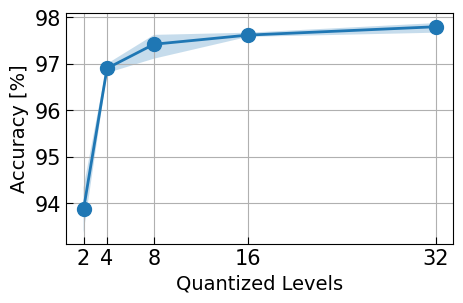

In [10]:
# Plotting QAT in num_levels VS accuracy

dir_load = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_num_levels_MNIST_MLP_analysis.pkl'
data = pickle.load( open(dir_load, 'rb') )
num_levels_list = data['num_levels_list']
acc_test_qat = data['acc_test_qat']

fig, ax = plt.subplots( figsize=(5,3) )
ax.plot( num_levels_list, acc_test_qat.mean( axis=1 )*100, marker='o', lw=2, ms=10, label='QAT' )
ax.fill_between( num_levels_list, 100*np.quantile( acc_test_qat, q=0.05, axis=1 ), 100*np.quantile( acc_test_qat, q=0.95, axis=1 ), alpha=0.25  )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
ax.set_xticks( num_levels_list )
ax.set_xlabel('Quantized Levels', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()

In [ ]:
# QAT: Noise in Backward phase
n_models = 5
noise_sd_list = np.array([0.001, 0.0025, 0.01, 0.025, 0.05, 0.1])
acc_test_qat_back = np.zeros( (len(noise_sd_list), n_models) )
data_loaders = [train_loader, test_loader]
num_levels = 4

for n, noise_sd in enumerate(noise_sd_list):
    for m in range(n_models):
        model = MLP(noise_inference=False)
        model.generate_hidden_weights()
        model_trained, _, [acc_test, _] = training_algo( training_type='qat_noise', model=model, data_loaders=data_loaders,
                                            clip_w=2.5, lr=1e-3, epochs=10, epochs_noise=0, num_levels=num_levels,
                                            print_every=1, verbose=False, device=device )
        acc_test_qat_back[n, m] = acc_test
    print(f'QAT, noise back {noise_sd}, Test Accuracy: {acc_test_qat_back[n].mean()*100:.2f}%')

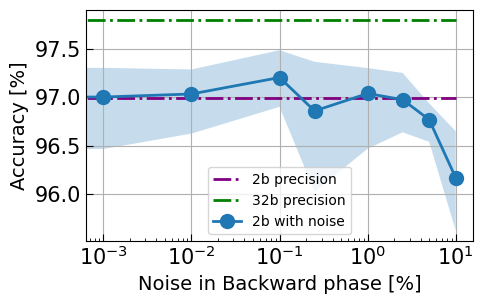

In [33]:
# Plotting QAT noise Back
dir_load = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_back_MNIST_MLP_analysis_extended.pkl'
data = pickle.load( open(dir_load, 'rb') )
noise_sd_list = data['noise_sd_list']
acc_test_qat_back = data['acc_test_qat_back']

# load the 2 bit case w/out noise
dir_load = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_num_levels_MNIST_MLP_analysis.pkl'
data_2b = pickle.load( open(dir_load, 'rb') )
acc_test_qat = data_2b['acc_test_qat']

fig, ax = plt.subplots( figsize=(5,3) )
# 2bit case
ax.hlines( acc_test_qat_back[0].mean( )*100, 100*noise_sd_list[0], 100*noise_sd_list[-1], color='purple', linestyles='-.', lw=2, label='2b precision' )
# 32bit case
ax.hlines( acc_test_qat[-1].mean()*100, 100*noise_sd_list[0], 100*noise_sd_list[-1], color='green', linestyles='-.', lw=2, label='32b precision' )
# noise backward
ax.plot( 100*noise_sd_list, np.mean(acc_test_qat_back, axis=1 )*100, marker='o', lw=2, ms=10, label='2b with noise' )
ax.fill_between( 100*noise_sd_list, 100*np.quantile( acc_test_qat_back, q=0.05, axis=1 ), 
                 100*np.quantile( acc_test_qat_back, q=0.95, axis=1 ), alpha=0.25  )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
ax.set_xticks( 100*noise_sd_list )
ax.set_xlabel('Noise in Backward phase [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.set_xscale('log')
ax.legend(prop={'size':10}, loc=8)
ax.grid()